Graph Embedding
----
This computes graph embeddings using semi-definite programming and then clustering of the graph embedding.

Creates a toy example.

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()
G.add_edges_from([(0,1),(1,2)])

For this toy example, computes the pairwise distance between nodes.

In [2]:
import numpy as np

all_paths = [x[1] for x in nx.all_pairs_shortest_path(G)]
N = G.order()
dist_list = []
for i in range(N):
    dist_list.append([len(all_paths[i][u])-1 for u in G.nodes()])
dist = np.matrix(dist_list)
dist

matrix([[0, 1, 2],
        [1, 0, 1],
        [2, 1, 0]])

Computes the graph embedding based on the distance matrix.

In [3]:
import cvxpy as cp
import scipy.linalg
# https://www.cvxpy.org/tutorial/advanced/index.html#semidefinite
# https://www.cvxpy.org/examples/basic/sdp.html

def embed_graph(N,dist):
    #dimension n of the matrix to optimize where N is the number of nodes
    n = N+1
    # Generate the objective function.
    C = np.zeros((n, n))
    C[n-1,n-1] = 1
    #Generate the constraints
    A = []
    b = []
    #lower bounds
    for i in range(0,N):
        for j in range(i+1,N):
            M = np.zeros((n,n))
            M[i,i] = 1
            M[j,j] = 1
            M[i,j] = -1
            M[j,i] = -1
            A.append(M)
            b.append(dist[i,j]**2)
    #upper bounds
    for i in range(0,N):
        for j in range(i+1,N):
            M = np.zeros((n,n))
            M[i,i] = 1
            M[j,j] = 1
            M[i,j] = -1
            M[j,i] = -1
            M[N,N] = -dist[i,j]**2
            A.append(M)
            b.append(0.0)
        
    # Create a symmetric matrix variable.
    X = cp.Variable((n,n), symmetric=True)
    # The operator >> means positive semidefinite.
    constraints = [X >> 0]
    constraints += [
        cp.trace(A[i]@X) >= b[i] for i in range(int(N*(N-1)/2))]
    constraints += [
        cp.trace(A[i]@X) <= b[i] for i in range(int(N*(N-1)/2),N*(N-1))]
    prob = cp.Problem(cp.Minimize(cp.trace(C@X)),constraints)
    prob.solve(verbose=False)

    #now to get the embedding, we need to factor X
    #we can do that with Cholesky decomposition if X > 0
    #L1 * L1.T = X
    try: 
        L = np.linalg.cholesky(X.value)
    except:
        #but otherwise, if X >=0, the Cholesky routine may produce an error
        #so we can use an L U decomposition A = P2 L2 U2
        (P, Ltmp, U) = scipy.linalg.lu(X.value)
        #from the LU decomposition, we get an L D U decomposition:
        #D is the diagonal of U
        D = np.diag(np.diag(U))   
        # Normalize rows of U
        #U /= np.diag(U)[:, None]
        # now we need the square root of D, so we can write L sqrt(D) * sqrt(D) U
        # because of numerical precision, might have negative values
        #print("warning: killing negative diagonal coefficients gives approximation errors")
        for i in range(n):
            if D[i,i] < 0:
                D[i,i] = 0
        L = P.dot(Ltmp.dot(np.sqrt(D)))
    #print("Therefore an embeeding is given by the rows of")
    #print(L)
    return(prob.value,L)

In [4]:
(Dex,Lex) = embed_graph(N,dist)

This tells that we have an isometric embedding.

In [5]:
Dex

1.000000000002172

This computes the distances in the graph embedding, for this example, this confirms that we have an isometric embedding.

In [6]:
dist_l2 = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        dist_l2[i,j] = np.linalg.norm(Lex[i,:]-Lex[j,:])
dist_l2

array([[0., 1., 2.],
       [1., 0., 1.],
       [2., 1., 0.]])

In [7]:
dist

matrix([[0, 1, 2],
        [1, 0, 1],
        [2, 1, 0]])

This computes in parallel two clusterings, one based on the graph distance, the other based on the embedding.

In [8]:
import time
import random
import numpy as np
import networkx as nx
import pylab as plt

def GGraphwithin_embed(G,sigma2,orig_nb):
    #take a networkx graph as input, and sigma2 (which means sigma**2) is the bandwidth parameter 
    #no of vertices 
    N = G.order()
    
    #if networkx returns a dictionary of shortest paths
    #paths = nx.all_pairs_shortest_path(G)
    #if networkx returns a generator for shortest paths
    paths = list(nx.all_pairs_shortest_path(G))
    
    #the input is one-dimensional
    n=1
    
    def EF(cur_label,new_members):
        #cur_label contains the current cluster
        #new_members is the list of nodes to choose a new cluster member from 
        N2 = len(cur_label)
        N1 = len(new_members)
        #initialization of the evaluation function
        Geval = 0
        Gevalmin = 1000
        new_member = 0
        #choose a new member
        for k1 in range(N1):
            #compute its distance with all members of the current cluster
            for k2 in range(N2):
                #some of the terms which do not influence the minimum have been ignored in the evaluation function
                ##if networkx returns a dictionary of shortest paths
                #x = len(paths[new_members[k1]][cur_label[k2]])
                ##if networkx returns a generator of shortest paths
                x = len(paths[new_members[k1]][1][cur_label[k2]])-1
                Geval = Geval + np.exp((-1/2)*(x*((1/(2*sigma2))*x))*(1/((2*sigma2)**(n/2))))
            Geval = Geval/(N2+1)                           
            #choose as new member the neighbour with the lowest Geval
            #either new member is not yet used, or it was used less efficiently
            valid = (evaluated_ef[new_members[k1]]==0 or evaluated_ef[new_members[k1]]>Geval)
            if Geval < Gevalmin and valid:
                Gevalmin = Geval
                new_member = new_members[k1]
        evaluated_ef[new_member] = Gevalmin     
        return new_member
    
    def EF_emb(cur_label,new_members,dist):
        #cur_label contains the current cluster
        #new_members is the list of nodes to choose a new cluster member from 
        N2 = len(cur_label)
        N1 = len(new_members)
        #initialization of the evaluation function
        Geval = 0
        Gevalmin = 1000
        new_member = 0
        #choose a new member
        for k1 in range(N1):
            #compute its distance with all members of the current cluster
            for k2 in range(N2):
                #some of the terms which do not influence the minimum have been ignored in the evaluation function
                ##if networkx returns a dictionary of shortest paths
                #x = len(paths[new_members[k1]][cur_label[k2]])
                ##if networkx returns a generator of shortest paths
                x = dist[new_members[k1],cur_label[k2]]
                Geval = Geval + np.exp((-1/2)*(x*((1/(2*sigma2))*x))*(1/((2*sigma2)**(n/2))))
            Geval = Geval/(N2+1)                           
            #choose as new member the neighbour with the lowest Geval
            #either new member is not yet used, or it was used less efficiently
            valid = (evaluated_efemb[new_members[k1]]==0 or evaluated_efemb[new_members[k1]]>Geval)
            if Geval < Gevalmin and valid:
                Gevalmin = Geval
                new_member = new_members[k1]
        evaluated_efemb[new_member] = Gevalmin     
        return new_member
    
    #initial labelling
    label = np.zeros(N)
    label_emb = np.zeros(N)
    #pick some nodes at random forming the original singleton clusters
    evaluated = random.sample(range(N),orig_nb)
    evaluated_ef = np.zeros(N)
    evaluated_efemb = np.zeros(N)
    #assign them each to their own clusters
    for i in range(len(evaluated)):
        label[evaluated[i]] = i+1 
        label_emb[evaluated[i]] = i+1 
    #tic
    t = time.time()    
    
    subgraphs = []
    embed_list = []
    distl2_list = []
    cnt = 0
    for i in evaluated:
        neigh = nx.single_source_shortest_path_length(G ,source=i, cutoff=2).keys()
        subg = G.subgraph([x for x in neigh])
        subgraphs.append(subg)
        Nsub = subg.order()
        all_paths_sub = [x[1] for x in nx.all_pairs_shortest_path(subg)]
        dist_list_sub = []
        for i in range(Nsub):
             dist_list_sub.append([len(all_paths_sub[i][u])-1 for u in subg.nodes()])
        distsub = np.matrix(dist_list_sub)
        (D,L) = embed_graph(Nsub,distsub)
        cnt = cnt + 1
        #print('embed subgraph', cnt)
        embed_list.append([D,L])
        dist_l2 = np.zeros((N,N))
        for i in range(Nsub):
             for j in range(i+1,Nsub):
                dist_l2[i,j] = np.linalg.norm(L[i,:]-L[j,:])
        #np.transpose(P).dot(dist_l2)
        distl2_list.append(dist_l2)
    listD = [(x[0],np.shape(x[1])[0]) for x in embed_list]
    #print(distl2_list)
   
    
    print('start embedded clustering')
    while np.count_nonzero(label_emb) < N:
        for l in range(orig_nb):
            #find all points belonging to cluster l
            cl = np.where((label_emb - (l+1)*np.ones(N)) == 0)[0]
            list_neighbours = []
            list_allneighbours = []
            for node in cl:
                list_neighbours.extend([neighb for neighb in list(G[node]) if label_emb[neighb] == 0])
                list_allneighbours.extend([neighb for neighb in list(G[node])])
            if len(list_neighbours) > 0:    
                #search only among non-labelled nodes: list_neighbours, otherwise, list_allneighbours
                new_member_l = EF_emb(cl,list_neighbours,distl2_list[l])
                label_emb[new_member_l] = l+1   
                
    print('start clustering')
    while np.count_nonzero(label) < N:
        for l in range(orig_nb):
            #find all points belonging to cluster l
            cl = np.where((label - (l+1)*np.ones(N)) == 0)[0]
            list_neighbours = []
            list_allneighbours = []
            for node in cl:
                list_neighbours.extend([neighb for neighb in list(G[node]) if label[neighb] == 0])
                list_allneighbours.extend([neighb for neighb in list(G[node])])
            if len(list_neighbours) > 0:    
                #search only among non-labelled nodes: list_neighbours, otherwise, list_allneighbours
                new_member_l = EF(cl,list_neighbours)
                label[new_member_l] = l+1   

    #toc 
    elapsed = time.time() - t
    print('time in secs:',elapsed)
    print('no of clusters:',orig_nb)
    
    return (list(label),list(label_emb),listD)

This plots the graph clustering.

In [9]:
def plot_cluster(G,labels,pos):
    #G is the graph, labels contains the clustering, 
    #pos is to use an existing graph layout
    
    val_map = {}
    for k in range(0,G.order()):
        val_map[k] = labels[k]

    values = [val_map.get(node, 0) for node in G.nodes()]

    #this fixes the size of the figure
    #plt.figure(1,figsize=(6,6)) 
    nx.draw(G, pos, cmap=plt.get_cmap('rainbow'), node_color=values, node_size = 50)
    plt.show()

This loads a graph sample to be clustered.

no of vertices 209


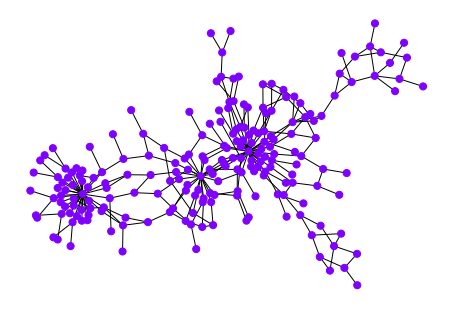

In [10]:
import networkx as nx
import pylab as plt

fh=open("/home/elise/Documents/NTUwork/BitcoinResearch/ClusteringJournal/subgraph1.txt", 'rb')
G1 = nx.read_edgelist(fh,delimiter=',',create_using=nx.Graph())
print('no of vertices',G1.order())
G1 = nx.convert_node_labels_to_integers(G1, first_label=0, ordering='default')
#computes the graph layout
pos1 = nx.nx_pydot.graphviz_layout(G1)
#plots the graph
plot_cluster(G1,[0 for x in G1.nodes()],pos1)

This compares the clustering obtained on the graph and via its embedding.

In [93]:
(G1initiallabels,G1initiallabels_emb,LDist) = GGraphwithin_embed(G1,0.01,50)

start embedded clustering
start clustering
time in secs: 74.11243939399719
no of clusters: 50


In [98]:
cnt = 0
list_distorsion = []
list_F = []
while cnt < 15:
    print(cnt)
    (G1initiallabels,G1initiallabels_emb,LDist) = GGraphwithin_embed(G1,0.01,50)
    list_distorsion.append(LDist)
    if sum((np.array(G1initiallabels)-np.array(G1initiallabels_emb))!=0) > 0:
        print('different for', cnt)
    list_F.append(Fmeasure(G1initiallabels,G1initiallabels_emb))
    cnt = cnt + 1

0
start embedded clustering
start clustering
time in secs: 68.54367756843567
no of clusters: 50
different for 0
1
start embedded clustering
start clustering
time in secs: 73.42941451072693
no of clusters: 50
different for 1
2
start embedded clustering
start clustering
time in secs: 84.13793611526489
no of clusters: 50
different for 2
3
start embedded clustering
start clustering
time in secs: 90.59587144851685
no of clusters: 50
different for 3
4
start embedded clustering
start clustering
time in secs: 83.42374610900879
no of clusters: 50
different for 4
5
start embedded clustering
start clustering
time in secs: 68.89084267616272
no of clusters: 50
different for 5
6
start embedded clustering
start clustering
time in secs: 71.19250154495239
no of clusters: 50
different for 6
7
start embedded clustering
start clustering
time in secs: 88.25491428375244
no of clusters: 50
different for 7
8
start embedded clustering
start clustering
time in secs: 63.756762981414795
no of clusters: 50
differe

In [100]:
listflat = [y for x in list_distorsion for y in x]
print('max distorsion', max([x[0] for x in listflat]))
print('mean distorsion per instance', [sum(x[0])/len(x) for x in list_distorsion])
print('mean distorsion', sum([x[0] for x in listflat])/len(listflat))
print('max graph size' ,max([x[1] for x in listflat]))
print('mean graph size per instance', [sum(x[1])/len(x) for x in list_distorsion])
print('mean graph size',sum([x[1] for x in listflat])/len(listflat))

max distorsion 2.7560368572723752
mean distorsion per instance [0.24000057890382404, 0.23179952543562984, 0.8389528278510823, 0.7988232014082339, 0.1266666887148389, 0.24000057890382404, 0.19999951868730176, 0.7988232014082339, 0.2312981017615468, 0.19055601883951026, 0.5991176503481125, 0.7988232014082339, 1.0332414800448675, 0.21929054742846268, 0.23129899728107225]
mean distorsion 1.8231466989196476
max graph size 71
mean graph size per instance [0.23129813151680514, 0.9477466793851653, 0.5982629787200152, 0.8835289440394068, 0.27741907167193514, 0.8790698791290421, 0.8389473684215334, 0.21230025544347986, 0.8389473684215334, 0.2312981017615468, 0.6073920876276939, 0.2599971194052573, 0.8790653036220831, 0.12666668871520184, 0.12666668871484058]
mean graph size 22.814666666666668


In [101]:
list_F

[0.9084886128364389,
 0.9715877437325905,
 0.9453993933265925,
 0.9646821392532795,
 0.9352396972245585,
 0.8775403856175091,
 0.9071969696969697,
 0.9957907396271798,
 0.974694589877836,
 0.9877551020408163,
 0.9017467248908297,
 0.9650194336479734,
 0.919891008174387,
 0.9462102689486552,
 0.8868421052631579]

In [102]:
sum(list_F)/len(list_F)

0.9392056609439183

This plots the graph clustering.

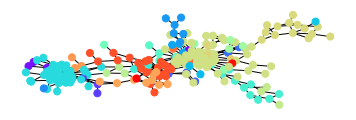

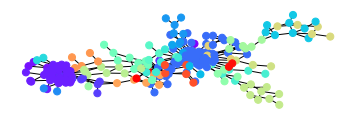

In [85]:
#this fixes the size of the figure
plt.figure(1) 

plt.subplot(2, 1, 1)
plot_cluster(G1,G1initiallabels,pos1)

plt.subplot(2, 1, 2)
plot_cluster(G1,G1initiallabels_emb,pos1)

In [90]:
def compute_pairs(labels):
    Lpairs = []
    clus_list = set(labels)
    for clus in clus_list: 
        s = [i for i, x in enumerate(labels) if x == clus]
        for i in range(len(s)):
            for j in range(i+1,len(s)):
                #[set(i) for i in itertools.combinations(s, 2)]
                Lpairs.extend([(s[i],s[j])])
    return Lpairs

def Fmeasure(labels,truthlabels):
    Pclus = set(compute_pairs(labels))
    Ptrue = set(compute_pairs(truthlabels))
    a = len(Pclus.intersection(Ptrue))
    b = len(Pclus-Ptrue)
    c = len(Ptrue-Pclus)
    F = (2*a)/(2*a+b+c)
    return F

In [94]:
Fmeasure(G1initiallabels,G1initiallabels_emb)

0.9403409090909091

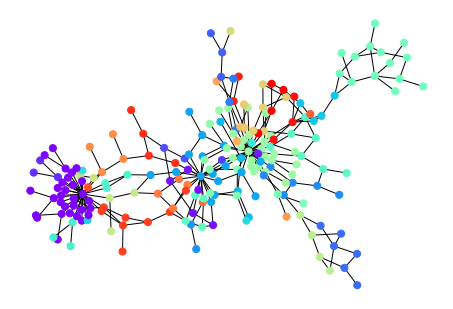

In [95]:
plot_cluster(G1,G1initiallabels_emb,pos1)

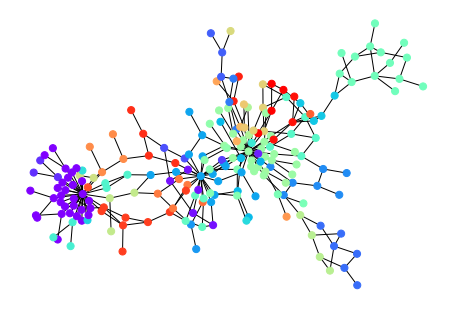

In [96]:
plot_cluster(G1,G1initiallabels,pos1)

In [31]:
import sys
print(sys.executable)

/usr/bin/python3


In [4]:
import sys
print(sys.path)

['', '/home/frederique/anaconda3/lib/python36.zip', '/home/frederique/anaconda3/lib/python3.6', '/home/frederique/anaconda3/lib/python3.6/lib-dynload', '/home/frederique/anaconda3/lib/python3.6/site-packages', '/home/frederique/anaconda3/lib/python3.6/site-packages/IPython/extensions', '/home/frederique/.ipython']
